In [48]:
"""
Date: 20.12.2022
Author: Kaufmann Stefan

MPC 

https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html
"""


import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt



# Modell

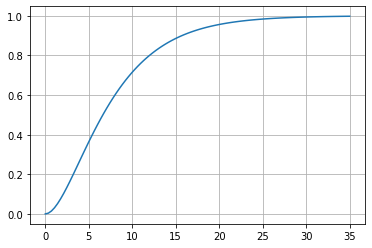

In [49]:
G = scipy.signal.lti([1], [15, 8, 1])

plt.plot(*G.step())
plt.grid(True)
plt.show()

# MPC

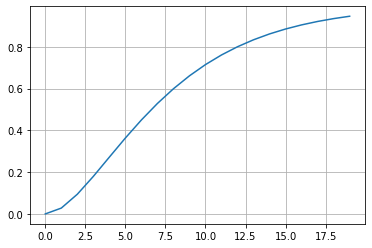

In [50]:
M = 10  # Control horizon
P = 20  # Prediction horizon
DeltaT = 1  # Sampling rate

tcontinuous = numpy.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon


tau_c = 1
r = 1 - numpy.exp(-tpredict/tau_c)



u = numpy.ones(M)



x0 = numpy.zeros(G.to_ss().A.shape[0])

def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return numpy.concatenate([u, numpy.repeat(u[-1], P-M)])

def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

plt.plot(tpredict, prediction(extend(u)))
plt.grid(True)
plt.show()



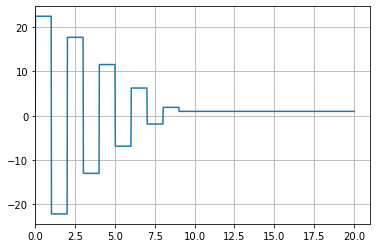

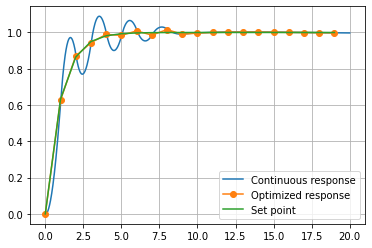

In [51]:
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    umag = numpy.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(numpy.abs(numpy.diff(u)))
    strongfinish = numpy.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0*constraintpenalty + 0*movepenalty + 0*strongfinish

result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun


ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]

def plotoutput(ucont, uopt):
    plt.figure()
    plt.grid(True)
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.legend()
    plt.grid(True)
    plt.show()

plotoutput(ucont, uopt)